# 2kr Analysis

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = '2kr.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

tIntervalAlpha = 0.95

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95, 0.99]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]
intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

# Computed
factorsCount = len(factors)
configsCount = 2**factorsCount
totalSims = configsCount*repetitionsCount

combinedFactors = list(chain(*[list(map(''.join, combinations(''.join(factors), i))) for i in range(1, factorsCount+1)]))
freedomDegrees = configsCount*(repetitionsCount - 1)


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 2*configsCount*repetitionsCount+1)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, 'config'] = cfg
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values(['config', 'repetition', 'qname'], inplace=True)
vectors = vectors[['config', 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        cfg = row['config']
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide['config'] == cfg) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value

## 2kr

In [8]:
cols = ['exp', 'I'] + combinedFactors
data = [[e, 1] + list(chain(*[list(map(np.prod, combinations(r, i))) for i in range(1, len(r)+1)])) for r,e in zip([list(x) for x in product([-1, 1], repeat=factorsCount)], range(0, configsCount))]
factorsMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')

computeMatrices = []
ciMatrices = []
errorVariances = []
skipped = []

for perfIndex, perfIndexDesc in perfIndexes:
    print("2^k*r analysis for the", perfIndexDesc)
    cols = ['exp'] + ['y' + str(i) for i in range(0, repetitionsCount)]
    data = [[i] + scalars_wide[scalars_wide.config == i][perfIndex].values.tolist() for i in range(0, configsCount)]
    ysMatrix = pd.DataFrame.from_records(data, columns=cols, index='exp')
    ysMatrix['mean'] = ysMatrix.mean(axis=1)
    next2kr = False
    for r in range(0, repetitionsCount):
        for c in range(0, configsCount):
            if math.isinf(ysMatrix['y' + str(r)].values[c]):
                print('!!! Observations contain infinite values. Skipping...')
                print()
                skipped.append(perfIndex)
                next2kr = True
                break
        if next2kr:
            break
        ysMatrix['e' + str(r)] = ysMatrix['y' + str(r)] - ysMatrix['mean']
    if next2kr:
        continue

    matrix = pd.concat([factorsMatrix, ysMatrix], axis=1)

    computeCols = ['idx', 'I'] + combinedFactors + ['e' + str(r) for r in range(0, repetitionsCount)]
    data = [['Sum'], ['Mean (Qi)'], ['SSQ']]
    SSE = 0
    for col in computeCols[1:]:
        sumvalue = np.sum(matrix[col].values * matrix['mean'].values)
        data[0].append(sumvalue)
        data[1].append(sumvalue / configsCount)
        if col in ['e' + str(r) for r in range(0, repetitionsCount)]:
            ssq = np.sum(matrix[col].values * matrix[col].values)
            data[2].append(ssq)
            SSE += ssq
        else:
            data[2].append('')
    computeMatrix = pd.DataFrame.from_records(data, columns=computeCols, index='idx')

    data = [['(2^k)*r*(qi)^2'], ['Variation'], ['Variation%']]
    SST = SSE
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        r2kqi2 = configsCount*repetitionsCount*(qi**2)
        data[0].append(r2kqi2)
        SST += r2kqi2
    data[0].append(SSE)
    idx = 1
    for col in combinedFactors:
        r2kqi2 = data[0][idx]
        var = r2kqi2 / SST
        data[1].append(var)
        data[2].append('{:.2%}'.format(var))
        idx += 1
    data[1].append(SST)
    data[2].append('{:.2%}'.format(SSE/SST))
    resultMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors + ['SSE/SST'], index='idx')

    errorVariance = SSE / freedomDegrees
    negativeInterval, positiveInterval = tuple(v*math.sqrt(errorVariance/(configsCount*repetitionsCount)) for v in stats.t.interval(tIntervalAlpha, freedomDegrees))
    data = [['CI+ Qi ({:.2%})'.format(tIntervalAlpha)], ['CI- Qi ({:.2%})'.format(tIntervalAlpha)], ['Distance (Qi)'], ['Zero Included'], ['CI+ Variation'], ['CI- Variation'], ['CI Distance (Variation)']]
    for col in combinedFactors:
        qi = computeMatrix.loc['Mean (Qi)', col]
        upper = qi + positiveInterval
        lower = qi + negativeInterval
        data[0].append(upper)
        data[1].append(lower)
        data[2].append(abs(upper - lower))
        data[3].append(upper >= 0 and lower <= 0)
        upper = (configsCount*repetitionsCount*(upper**2))/SST
        lower = (configsCount*repetitionsCount*(lower**2))/SST
        data[4].append(upper)
        data[5].append(lower)
        data[6].append(abs(upper - lower))
    ciMatrix = pd.DataFrame.from_records(data, columns=['idx'] + combinedFactors, index='idx')

    computeMatrices.append(computeMatrix)
    ciMatrices.append(ciMatrix)
    errorVariances.append(errorVariance)

    display(matrix)
    display(computeMatrix)
    display(resultMatrix)
    display(ciMatrix)

    print('SSE =', SSE)
    print('SST =', SST)
    print('Error variance =', errorVariance)
    print('Unexplained Variation =', '{:.2%}'.format(SSE/SST))
    print()
    print('####################################')
    print()

2^k*r analysis for the percentage of covered users


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,1.00000,1.00000,0.999110,1.000000,0.99911,1.00000,0.998221,0.994662,1.00000,1.000000,0.999110,0.000890,0.000890,-1.110223e-16,0.000890,-1.110223e-16,0.000890,-0.000890,-0.004448,0.000890,0.000890
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1.00000,1.00000,0.999110,1.000000,0.99911,1.00000,1.000000,1.000000,1.00000,0.999110,0.999733,0.000267,0.000267,-6.227758e-04,0.000267,-6.227758e-04,0.000267,0.000267,0.000267,0.000267,-0.000623
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1.00000,1.00000,1.000000,0.998221,1.00000,1.00000,1.000000,0.999110,1.00000,1.000000,0.999733,0.000267,0.000267,2.669039e-04,-0.001512,2.669039e-04,0.000267,0.000267,-0.000623,0.000267,0.000267
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1.00000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,1.00000,0.99911,0.997331,0.997331,1.00000,0.99911,1.000000,1.000000,0.99911,1.000000,0.999199,0.000801,-0.000089,-1.868327e-03,-0.001868,8.007117e-04,-0.000089,0.000801,0.000801,-0.000089,0.000801
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,1.00000,1.00000,0.999110,0.999110,1.00000,1.00000,0.999110,1.000000,1.00000,0.998221,0.999555,0.000445,0.000445,-4.448399e-04,-0.000445,4.448399e-04,0.000445,-0.000445,0.000445,0.000445,-0.001335
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1.00000,1.00000,1.000000,1.000000,1.00000,0.99911,0.998221,1.000000,1.00000,0.999110,0.999644,0.000356,0.000356,3.558719e-04,0.000356,3.558719e-04,-0.000534,-0.001423,0.000356,0.000356,-0.000534
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1.00000,1.00000,1.000000,1.000000,1.00000,0.99911,1.000000,1.000000,1.00000,1.000000,0.999911,0.000089,0.000089,8.896797e-05,0.000089,8.896797e-05,-0.000801,0.000089,0.000089,0.000089,0.000089
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,1.00000,1.00000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,15.996619,0.002847,-0.000534,0.001601,0.001779,0.0,-0.001779,-0.001246,-0.000178,-0.0,-0.000356,0.0,0.000534,0.000534,0.000356,-0.000178,0.002489,0.002490,-0.002845,-0.001956,0.001601,-0.000179,-0.001067,-0.002844,0.002490,-0.000179
Mean (Qi),0.999789,0.000178,-0.000033,0.0001,0.000111,0.0,-0.000111,-0.000078,-0.000011,-0.0,-0.000022,0.0,0.000033,0.000033,0.000022,-0.000011,0.000156,0.000156,-0.000178,-0.000122,0.000100,-0.000011,-0.000067,-0.000178,0.000156,-0.000011
SSQ,,,,,,,,,,,,,,,,,0.000003,0.000001,0.000005,0.000007,0.000001,0.000003,0.000004,0.000021,0.000001,0.000004


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,0.000005,0.0,0.000002,0.000002,0.0,0.000002,0.000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00005
Variation,0.081038,0.002849,0.025641,0.031656,0.0,0.031656,0.015511,0.000317,0.0,0.001266,0.0,0.002849,0.002849,0.001266,0.000317,0.000063
Variation%,8.10%,0.28%,2.56%,3.17%,0.00%,3.17%,1.55%,0.03%,0.00%,0.13%,0.00%,0.28%,0.28%,0.13%,0.03%,80.28%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),0.00027,0.000059,0.000192,0.000203,0.000092,-0.000019,0.000014,0.000081,0.000092,0.00007,0.000092,0.000126,0.000126,0.000114,0.000081
CI- Qi (95.00%),0.000086,-0.000126,0.000008,0.000019,-0.000092,-0.000203,-0.00017,-0.000103,-0.000092,-0.000114,-0.000092,-0.000059,-0.000059,-0.00007,-0.000103
Distance (Qi),0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184,0.000184
Zero Included,False,True,False,False,True,False,True,True,True,True,True,True,True,True,True
CI+ Variation,0.186843,0.008875,0.094685,0.105951,0.02178,0.00092,0.000531,0.016845,0.02178,0.012543,0.02178,0.040384,0.040384,0.03355,0.016845
CI- Variation,0.018794,0.040384,0.000157,0.00092,0.02178,0.105951,0.074052,0.027348,0.02178,0.03355,0.02178,0.008875,0.008875,0.012543,0.027348
CI Distance (Variation),0.168049,0.031509,0.094528,0.105031,0.0,0.105031,0.073522,0.010503,0.0,0.021006,0.0,0.031509,0.031509,0.021006,0.010503


SSE = 5.018300173503474e-05
SST = 6.251108141994044e-05
Error variance = 3.484930676044079e-07
Unexplained Variation = 80.28%

####################################

2^k*r analysis for the total number of collisions


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,789.0,615.0,753.0,809.0,663.0,775.0,862.0,662.0,673.0,740.0,734.1,54.9,-119.1,18.9,74.9,-71.1,40.9,127.9,-72.1,-61.1,5.9
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,475.0,544.0,491.0,404.0,448.0,468.0,508.0,403.0,405.0,459.0,460.5,14.5,83.5,30.5,-56.5,-12.5,7.5,47.5,-57.5,-55.5,-1.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,985.0,1017.0,951.0,1044.0,992.0,1042.0,1069.0,1010.0,993.0,989.0,1009.2,-24.2,7.8,-58.2,34.8,-17.2,32.8,59.8,0.8,-16.2,-20.2
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,702.0,760.0,727.0,661.0,672.0,664.0,742.0,656.0,588.0,649.0,682.1,19.9,77.9,44.9,-21.1,-10.1,-18.1,59.9,-26.1,-94.1,-33.1
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,736.0,725.0,691.0,571.0,684.0,742.0,696.0,606.0,742.0,667.0,686.0,50.0,39.0,5.0,-115.0,-2.0,56.0,10.0,-80.0,56.0,-19.0
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,421.0,495.0,425.0,375.0,437.0,415.0,337.0,500.0,448.0,498.0,435.1,-14.1,59.9,-10.1,-60.1,1.9,-20.1,-98.1,64.9,12.9,62.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,977.0,1013.0,1070.0,910.0,980.0,1016.0,966.0,889.0,991.0,994.0,980.6,-3.6,32.4,89.4,-70.6,-0.6,35.4,-14.6,-91.6,10.4,13.4
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,667.0,639.0,710.0,617.0,626.0,569.0,602.0,582.0,657.0,586.0,625.5,41.5,13.5,84.5,-8.5,0.5,-56.5,-23.5,-43.5,31.5,-39.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,3460.0,3963.0,3382.0,3186.0,3856.0,3444.0,3352.0,3411.0,3031.0,3522.0,3460.7,-0.7,502.3,-78.7,-274.7,395.3,-16.7,-108.7,-49.7,-429.7,61.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,34712.4,23486.2,-1611.8,9731.4,-6328.8,-1294.4,7768.0,-3915.4,-108.8,-312.2,340.2,-85.4,-301.6,655.6,-717.6,-616.2,-349340.66000,3354013.040,-2.376243e+06,-2.970970e+06,-1.176447e+06,-457353.1600,1096095.440,3.434845e+06,-523857.9600,-30740.96
Mean (Qi),2169.525,1467.8875,-100.7375,608.2125,-395.55,-80.9,485.5,-244.7125,-6.8,-19.5125,21.2625,-5.3375,-18.85,40.975,-44.85,-38.5125,-21833.79125,209625.815,-1.485152e+05,-1.856856e+05,-7.352795e+04,-28584.5725,68505.965,2.146778e+05,-32741.1225,-1921.31
SSQ,,,,,,,,,,,,,,,,,592016.26000,423172.860,3.636361e+05,3.741087e+05,6.045703e+05,253412.2600,457872.060,3.795353e+05,352744.8600,153488.86


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,344750994.025,1623687.025,59187591.225,25033568.4,1047169.6,37713640.0,9581473.225,7398.4,60918.025,72335.025,4558.225,56851.6,268632.1,321843.6,237314.025,3954557.4
Variation,0.712409,0.003355,0.122308,0.051731,0.002164,0.077933,0.0198,0.000015,0.000126,0.000149,0.000009,0.000117,0.000555,0.000665,0.00049,483922531.9
Variation%,71.24%,0.34%,12.23%,5.17%,0.22%,7.79%,1.98%,0.00%,0.01%,0.01%,0.00%,0.01%,0.06%,0.07%,0.05%,0.82%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),1493.782804,-74.842196,634.107804,-369.654696,-55.004696,511.395304,-218.817196,19.095304,6.382804,47.157804,20.557804,7.045304,66.870304,-18.954696,-12.617196
CI- Qi (95.00%),1441.992196,-126.632804,582.317196,-421.445304,-106.795304,459.604696,-270.607804,-32.695304,-45.407804,-4.632804,-31.232804,-44.745304,15.079696,-70.745304,-64.407804
Distance (Qi),51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608,51.790608
Zero Included,False,False,False,False,False,False,False,True,True,True,True,True,False,False,False
CI+ Variation,0.737767,0.001852,0.132944,0.045179,0.001,0.086468,0.015831,0.000121,0.000013,0.000735,0.00014,0.000016,0.001478,0.000119,0.000053
CI- Variation,0.687496,0.005302,0.112115,0.058725,0.003771,0.069841,0.024212,0.000353,0.000682,0.000007,0.000323,0.000662,0.000075,0.001655,0.001372
CI Distance (Variation),0.050271,0.00345,0.02083,0.013546,0.002771,0.016627,0.008381,0.000233,0.000668,0.000728,0.000183,0.000646,0.001403,0.001536,0.001319


SSE = 3954557.3999999994
SST = 483922531.89999986
Error variance = 27462.204166666663
Unexplained Variation = 0.82%

####################################

2^k*r analysis for the total number of messages sent


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,870.0,881.0,892.0,900.0,875.0,899.0,909.0,860.0,893.0,884.0,886.3,-16.3,-5.3,5.7,13.7,-11.3,12.7,22.7,-26.3,6.7,-2.3
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,835.0,865.0,844.0,832.0,836.0,830.0,845.0,838.0,830.0,840.0,839.5,-4.5,25.5,4.5,-7.5,-3.5,-9.5,5.5,-1.5,-9.5,0.5
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,1124.0,1123.0,1123.0,1122.0,1122.0,1122.0,1123.0,1122.0,1121.0,1123.0,1122.5,1.5,0.5,0.5,-0.5,-0.5,-0.5,0.5,-0.5,-1.5,0.5
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,1124.0,1121.0,1124.0,1120.0,1121.0,1123.0,1122.0,1124.0,1119.0,1122.0,1122.0,2.0,-1.0,2.0,-2.0,-1.0,1.0,0.0,2.0,-3.0,0.0
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,858.0,894.0,878.0,832.0,877.0,863.0,873.0,851.0,883.0,887.0,869.6,-11.6,24.4,8.4,-37.6,7.4,-6.6,3.4,-18.6,13.4,17.4
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,824.0,816.0,812.0,781.0,801.0,801.0,776.0,807.0,798.0,809.0,802.5,21.5,13.5,9.5,-21.5,-1.5,-1.5,-26.5,4.5,-4.5,6.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,1121.0,1119.0,1119.0,1117.0,1120.0,1113.0,1109.0,1120.0,1123.0,1117.0,1117.8,3.2,1.2,1.2,-0.8,2.2,-4.8,-8.8,2.2,5.2,-0.8
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,1104.0,1098.0,1104.0,1102.0,1096.0,1094.0,1102.0,1103.0,1106.0,1097.0,1100.6,3.4,-2.6,3.4,1.4,-4.6,-6.6,1.4,2.4,5.4,-3.6
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,700.0,725.0,639.0,633.0,723.0,678.0,688.0,688.0,623.0,693.0,679.0,21.0,46.0,-40.0,-46.0,44.0,-1.0,9.0,9.0,-56.0,14.0


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,14309.3,-1412.3,-468.7,2998.3,-677.7,-309.1,868.3,-414.5,-116.9,-230.5,244.9,-172.1,-156.5,52.5,-167.5,-174.7,89026.830000,20450.530000,-56720.870000,-110584.870000,-83488.670000,49031.130000,41216.530000,60780.630000,-43934.070000,34222.830000
Mean (Qi),894.33125,-88.26875,-29.29375,187.39375,-42.35625,-19.31875,54.26875,-25.90625,-7.30625,-14.40625,15.30625,-10.75625,-9.78125,3.28125,-10.46875,-10.91875,5564.176875,1278.158125,-3545.054375,-6911.554375,-5218.041875,3064.445625,2576.033125,3798.789375,-2745.879375,2138.926875
SSQ,,,,,,,,,,,,,,,,,8398.170000,7140.770000,4912.570000,8248.570000,11595.170000,4025.570000,7000.770000,12654.570000,8581.970000,4795.170000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1246619.55625,137299.80625,5618626.80625,287048.30625,59714.25625,471215.55625,107381.40625,8541.00625,33206.40625,37485.00625,18511.50625,15307.65625,1722.65625,17535.15625,19075.05625,77353.3
Variation,0.152835,0.016833,0.688841,0.035192,0.007321,0.057771,0.013165,0.001047,0.004071,0.004596,0.00227,0.001877,0.000211,0.00215,0.002339,8156643.44375
Variation%,15.28%,1.68%,68.88%,3.52%,0.73%,5.78%,1.32%,0.10%,0.41%,0.46%,0.23%,0.19%,0.02%,0.21%,0.23%,0.95%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-84.647058,-25.672058,191.015442,-38.734558,-15.697058,57.890442,-22.284558,-3.684558,-10.784558,18.927942,-7.134558,-6.159558,6.902942,-6.847058,-7.297058
CI- Qi (95.00%),-91.890442,-32.915442,183.772058,-45.977942,-22.940442,50.647058,-29.527942,-10.927942,-18.027942,11.684558,-14.377942,-13.402942,-0.340442,-14.090442,-14.540442
Distance (Qi),7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384,7.243384
Zero Included,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
CI+ Variation,0.14055,0.012928,0.715724,0.029431,0.004833,0.065739,0.009741,0.000266,0.002281,0.007028,0.000998,0.000744,0.000935,0.00092,0.001044
CI- Variation,0.165634,0.021252,0.662472,0.041467,0.010323,0.050317,0.017103,0.002343,0.006375,0.002678,0.004055,0.003524,0.000002,0.003895,0.004147
CI Distance (Variation),0.025083,0.008324,0.053252,0.012036,0.00549,0.015422,0.007362,0.002076,0.004094,0.00435,0.003057,0.00278,0.000932,0.002975,0.003103


SSE = 77353.3
SST = 8156643.44375
Error variance = 537.1756944444445
Unexplained Variation = 0.95%

####################################

2^k*r analysis for the Broadcast time needed to reach the 25th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,79.0,65.0,65.0,72.0,64.0,78.0,78.0,63.0,87.0,108.0,75.9,3.1,-10.9,-10.9,-3.9,-11.9,2.1,2.1,-12.9,11.1,32.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,89.0,95.0,86.0,68.0,148.0,105.0,98.0,114.0,67.0,108.0,97.8,-8.8,-2.8,-11.8,-29.8,50.2,7.2,0.2,16.2,-30.8,10.2
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,96.0,83.0,77.0,60.0,148.0,114.0,57.0,107.0,103.0,99.0,94.4,1.6,-11.4,-17.4,-34.4,53.6,19.6,-37.4,12.6,8.6,4.6
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,98.0,86.0,61.0,85.0,104.0,66.0,126.0,80.0,68.0,92.0,86.6,11.4,-0.6,-25.6,-1.6,17.4,-20.6,39.4,-6.6,-18.6,5.4
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,143.0,133.0,112.0,113.0,132.0,153.0,154.0,112.0,112.0,111.0,127.5,15.5,5.5,-15.5,-14.5,4.5,25.5,26.5,-15.5,-15.5,-16.5
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,171.0,117.0,145.0,217.0,125.0,100.0,139.0,122.0,132.0,197.0,146.5,24.5,-29.5,-1.5,70.5,-21.5,-46.5,-7.5,-24.5,-14.5,50.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,139.0,110.0,113.0,120.0,112.0,184.0,203.0,114.0,113.0,135.0,134.3,4.7,-24.3,-21.3,-14.3,-22.3,49.7,68.7,-20.3,-21.3,0.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,141.0,147.0,174.0,102.0,239.0,120.0,119.0,195.0,123.0,125.0,148.5,-7.5,-1.5,25.5,-46.5,90.5,-28.5,-29.5,46.5,-25.5,-23.5
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,26.0,23.0,26.0,43.0,24.0,49.0,29.0,34.0,32.0,24.0,31.0,-5.0,-8.0,-5.0,12.0,-7.0,18.0,-2.0,3.0,1.0,-7.0


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,1249.1,-573.9,294.5,12.3,63.1,-109.7,-19.9,-31.5,1.7,24.1,-26.5,-1.3,-14.1,42.5,23.3,-26.5,2852.290000,-9176.210000,-6029.710000,-3539.710000,19582.890000,810.390000,8124.490000,-1547.710000,-14805.210000,3728.490000
Mean (Qi),78.06875,-35.86875,18.40625,0.76875,3.94375,-6.85625,-1.24375,-1.96875,0.10625,1.50625,-1.65625,-0.08125,-0.88125,2.65625,1.45625,-1.65625,178.268125,-573.513125,-376.856875,-221.231875,1223.930625,50.649375,507.780625,-96.731875,-925.325625,233.030625
SSQ,,,,,,,,,,,,,,,,,1705.210000,2123.210000,3342.210000,12331.210000,15896.010000,8750.010000,10108.810000,4514.210000,3582.210000,5023.810000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,205850.75625,54206.40625,94.55625,2488.50625,7521.30625,247.50625,620.15625,1.80625,363.00625,438.90625,1.05625,124.25625,1128.90625,339.30625,438.90625,67376.9
Variation,0.603239,0.15885,0.000277,0.007292,0.022041,0.000725,0.001817,0.000005,0.001064,0.001286,0.000003,0.000364,0.003308,0.000994,0.001286,341242.24375
Variation%,60.32%,15.89%,0.03%,0.73%,2.20%,0.07%,0.18%,0.00%,0.11%,0.13%,0.00%,0.04%,0.33%,0.10%,0.13%,19.74%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-32.488665,21.786335,4.148835,7.323835,-3.476165,2.136335,1.411335,3.486335,4.886335,1.723835,3.298835,2.498835,6.036335,4.836335,1.723835
CI- Qi (95.00%),-39.248835,15.026165,-2.611335,0.563665,-10.236335,-4.623835,-5.348835,-3.273835,-1.873835,-5.036335,-3.461335,-4.261335,-0.723835,-1.923835,-5.036335
Distance (Qi),6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169,6.760169
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.494904,0.222549,0.008071,0.02515,0.005666,0.00214,0.000934,0.005699,0.011195,0.001393,0.005102,0.002928,0.017085,0.010967,0.001393
CI- Variation,0.722289,0.105865,0.003197,0.000149,0.04913,0.010024,0.013415,0.005025,0.001646,0.011893,0.005618,0.008514,0.000246,0.001735,0.011893
CI Distance (Variation),0.227385,0.116684,0.004873,0.025001,0.043464,0.007885,0.012481,0.000674,0.009549,0.0105,0.000515,0.005587,0.016839,0.009232,0.0105


SSE = 67376.9
SST = 341242.24374999997
Error variance = 467.8951388888888
Unexplained Variation = 19.74%

####################################

2^k*r analysis for the Broadcast time needed to reach the 50th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,128.0,110.0,103.0,120.0,110.0,122.0,121.0,89.0,132.0,160.0,119.5,8.5,-9.5,-16.5,0.5,-9.5,2.5,1.5,-30.5,12.5,40.5
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,135.0,157.0,137.0,106.0,209.0,163.0,151.0,174.0,118.0,161.0,151.1,-16.1,5.9,-14.1,-45.1,57.9,11.9,-0.1,22.9,-33.1,9.9
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,147.0,133.0,130.0,89.0,194.0,169.0,103.0,163.0,154.0,153.0,143.5,3.5,-10.5,-13.5,-54.5,50.5,25.5,-40.5,19.5,10.5,9.5
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,157.0,144.0,99.0,133.0,149.0,108.0,188.0,126.0,99.0,150.0,135.3,21.7,8.7,-36.3,-2.3,13.7,-27.3,52.7,-9.3,-36.3,14.7
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,232.0,206.0,178.0,180.0,209.0,246.0,252.0,190.0,180.0,160.0,203.3,28.7,2.7,-25.3,-23.3,5.7,42.7,48.7,-13.3,-23.3,-43.3
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,273.0,166.0,256.0,321.0,208.0,178.0,210.0,184.0,217.0,304.0,231.7,41.3,-65.7,24.3,89.3,-23.7,-53.7,-21.7,-47.7,-14.7,72.3
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,227.0,163.0,177.0,214.0,168.0,286.0,295.0,208.0,160.0,187.0,208.5,18.5,-45.5,-31.5,5.5,-40.5,77.5,86.5,-0.5,-48.5,-21.5
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,238.0,247.0,255.0,160.0,340.0,193.0,193.0,290.0,212.0,209.0,233.7,4.3,13.3,21.3,-73.7,106.3,-40.7,-40.7,56.3,-21.7,-24.7
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,48.0,36.0,40.0,64.0,35.0,71.0,49.0,52.0,48.0,45.0,48.8,-0.8,-12.8,-8.8,15.2,-13.8,22.2,0.2,3.2,-0.8,-3.8


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,1974.0,-879.2,477.8,16.4,96.6,-177.8,-14.4,-57.4,4.2,32.4,-32.6,6.2,-28.0,53.4,40.8,-32.4,15348.2800,-20276.9200,-8657.22000,-8020.32,31649.18000,5202.480,18274.18000,-1637.3200,-33241.3200,1358.98000
Mean (Qi),123.375,-54.95,29.8625,1.025,6.0375,-11.1125,-0.9,-3.5875,0.2625,2.025,-2.0375,0.3875,-1.75,3.3375,2.55,-2.025,959.2675,-1267.3075,-541.07625,-501.27,1978.07375,325.155,1142.13625,-102.3325,-2077.5825,84.93625
SSQ,,,,,,,,,,,,,,,,,5556.7200,7486.1200,6848.72000,23872.92,22095.92000,17871.320,17885.92000,8889.9200,7565.9200,11539.32000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,483120.4,142683.025,168.1,5832.225,19758.025,129.6,2059.225,11.025,656.1,664.225,24.025,490.0,1782.225,1040.4,656.1,129612.8
Variation,0.612563,0.180912,0.000213,0.007395,0.025052,0.000164,0.002611,0.000014,0.000832,0.000842,0.00003,0.000621,0.00226,0.001319,0.000832,788687.5
Variation%,61.26%,18.09%,0.02%,0.74%,2.51%,0.02%,0.26%,0.00%,0.08%,0.08%,0.00%,0.06%,0.23%,0.13%,0.08%,16.43%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-50.261909,34.550591,5.713091,10.725591,-6.424409,3.788091,1.100591,4.950591,6.713091,2.650591,5.075591,2.938091,8.025591,7.238091,2.663091
CI- Qi (95.00%),-59.638091,25.174409,-3.663091,1.349409,-15.800591,-5.588091,-8.275591,-4.425591,-2.663091,-6.725591,-4.300591,-6.438091,-1.350591,-2.138091,-6.713091
Distance (Qi),9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182,9.376182
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.512499,0.242173,0.006622,0.023338,0.008373,0.002911,0.000246,0.004972,0.009142,0.001425,0.005226,0.001751,0.013067,0.010628,0.001439
CI- Variation,0.721543,0.128568,0.002722,0.000369,0.050648,0.006335,0.013894,0.003973,0.001439,0.009176,0.003752,0.008409,0.00037,0.000927,0.009142
CI Distance (Variation),0.209044,0.113605,0.003899,0.022968,0.042275,0.003424,0.013648,0.000999,0.007704,0.007751,0.001474,0.006657,0.012697,0.009701,0.007704


SSE = 129612.8
SST = 788687.4999999999
Error variance = 900.088888888889
Unexplained Variation = 16.43%

####################################

2^k*r analysis for the Broadcast time needed to reach the 75th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,179.0,147.0,152.0,159.0,154.0,166.0,172.0,115.0,183.0,199.0,162.6,16.4,-15.6,-10.6,-3.6,-8.6,3.4,9.4,-47.6,20.4,36.4
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,197.0,218.0,177.0,141.0,259.0,206.0,195.0,230.0,159.0,215.0,199.7,-2.7,18.3,-22.7,-58.7,59.3,6.3,-4.7,30.3,-40.7,15.3
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,189.0,178.0,173.0,109.0,230.0,214.0,144.0,207.0,199.0,201.0,184.4,4.6,-6.4,-11.4,-75.4,45.6,29.6,-40.4,22.6,14.6,16.6
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,215.0,195.0,144.0,186.0,206.0,150.0,232.0,177.0,133.0,199.0,183.7,31.3,11.3,-39.7,2.3,22.3,-33.7,48.3,-6.7,-50.7,15.3
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,312.0,271.0,247.0,255.0,289.0,332.0,340.0,270.0,249.0,204.0,276.9,35.1,-5.9,-29.9,-21.9,12.1,55.1,63.1,-6.9,-27.9,-72.9
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,353.0,230.0,342.0,388.0,295.0,255.0,299.0,254.0,292.0,397.0,310.5,42.5,-80.5,31.5,77.5,-15.5,-55.5,-11.5,-56.5,-18.5,86.5
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,304.0,223.0,233.0,295.0,219.0,352.0,383.0,291.0,207.0,252.0,275.9,28.1,-52.9,-42.9,19.1,-56.9,76.1,107.1,15.1,-68.9,-23.9
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,331.0,326.0,361.0,200.0,412.0,288.0,277.0,386.0,281.0,279.0,314.1,16.9,11.9,46.9,-114.1,97.9,-26.1,-37.1,71.9,-33.1,-35.1
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,70.0,48.0,61.0,82.0,50.0,91.0,69.0,74.0,71.0,62.0,67.8,2.2,-19.8,-6.8,14.2,-17.8,23.2,1.2,6.2,3.2,-5.8


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,2658.2,-1157.4,654.0,2.0,135.0,-240.0,-14.8,-81.4,5.4,42.4,-25.2,11.8,-28.4,41.2,46.6,-38.2,31435.70000,-31239.90000,-3859.0000,-30678.6000,42027.70000,11056.2000,39354.800,4465.0000,-59501.8000,-3060.10000
Mean (Qi),166.1375,-72.3375,40.875,0.125,8.4375,-15.0,-0.925,-5.0875,0.3375,2.65,-1.575,0.7375,-1.775,2.575,2.9125,-2.3875,1964.73125,-1952.49375,-241.1875,-1917.4125,2626.73125,691.0125,2459.675,279.0625,-3718.8625,-191.25625
SSQ,,,,,,,,,,,,,,,,,8828.10000,11465.30000,11250.5000,34024.7000,23572.10000,19451.1000,22443.900,14732.5000,13952.1000,18448.70000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,837234.225,267322.5,2.5,11390.625,36000.0,136.9,4141.225,18.225,1123.6,396.9,87.025,504.1,1060.9,1357.225,912.025,178169.0
Variation,0.624868,0.199516,0.000002,0.008501,0.026869,0.000102,0.003091,0.000014,0.000839,0.000296,0.000065,0.000376,0.000792,0.001013,0.000681,1339856.975
Variation%,62.49%,19.95%,0.00%,0.85%,2.69%,0.01%,0.31%,0.00%,0.08%,0.03%,0.01%,0.04%,0.08%,0.10%,0.07%,13.30%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-66.840976,46.371524,5.621524,13.934024,-9.503476,4.571524,0.409024,5.834024,8.146524,3.921524,6.234024,3.721524,8.071524,8.409024,3.109024
CI- Qi (95.00%),-77.834024,35.378476,-5.371524,2.940976,-20.496524,-6.421524,-10.584024,-5.159024,-2.846524,-7.071524,-4.759024,-7.271524,-2.921524,-2.584024,-7.884024
Distance (Qi),10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048,10.993048
Zero Included,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True
CI+ Variation,0.533516,0.256782,0.003774,0.023185,0.010785,0.002496,0.00002,0.004064,0.007925,0.001836,0.004641,0.001654,0.00778,0.008444,0.001154
CI- Variation,0.723437,0.149465,0.003446,0.001033,0.050167,0.004924,0.013377,0.003178,0.000968,0.005972,0.002705,0.006314,0.001019,0.000797,0.007423
CI Distance (Variation),0.189921,0.107317,0.000328,0.022153,0.039382,0.002429,0.013357,0.000886,0.006958,0.004135,0.001936,0.00466,0.006761,0.007647,0.006268


SSE = 178169.0
SST = 1339856.975
Error variance = 1237.2847222222222
Unexplained Variation = 13.30%

####################################

2^k*r analysis for the Broadcast time needed to reach the 90th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,210.0,175.0,186.0,185.0,178.0,201.0,201.0,137.0,219.0,224.0,191.6,18.4,-16.6,-5.6,-6.6,-13.6,9.4,9.4,-54.6,27.4,32.4
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,232.0,257.0,218.0,175.0,289.0,233.0,230.0,261.0,187.0,252.0,233.4,-1.4,23.6,-15.4,-58.4,55.6,-0.4,-3.4,27.6,-46.4,18.6
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,217.0,210.0,203.0,127.0,254.0,243.0,171.0,236.0,228.0,227.0,211.6,5.4,-1.6,-8.6,-84.6,42.4,31.4,-40.6,24.4,16.4,15.4
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,244.0,223.0,172.0,223.0,237.0,178.0,258.0,212.0,151.0,234.0,213.2,30.8,9.8,-41.2,9.8,23.8,-35.2,44.8,-1.2,-62.2,20.8
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,368.0,329.0,291.0,301.0,337.0,395.0,403.0,313.0,296.0,245.0,327.8,40.2,1.2,-36.8,-26.8,9.2,67.2,75.2,-14.8,-31.8,-82.8
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,411.0,281.0,389.0,446.0,343.0,299.0,362.0,301.0,345.0,462.0,363.9,47.1,-82.9,25.1,82.1,-20.9,-64.9,-1.9,-62.9,-18.9,98.1
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,373.0,262.0,275.0,345.0,266.0,408.0,420.0,321.0,242.0,295.0,320.7,52.3,-58.7,-45.7,24.3,-54.7,87.3,99.3,0.3,-78.7,-25.7
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,396.0,381.0,413.0,239.0,465.0,341.0,335.0,440.0,342.0,348.0,370.0,26.0,11.0,43.0,-131.0,95.0,-29.0,-35.0,70.0,-28.0,-22.0
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,83.0,59.0,73.0,99.0,62.0,108.0,83.0,88.0,85.0,73.0,81.3,1.7,-22.3,-8.3,17.7,-19.3,26.7,1.7,6.7,3.7,-8.3


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,3122.5,-1341.9,771.3,-9.3,160.9,-293.9,-6.9,-96.7,11.9,50.5,-20.9,13.5,-33.5,33.1,57.9,-48.9,51711.090000,-34152.010000,-9343.210000,-41749.910000,42668.090000,14494.290000,53664.390000,-7230.310000,-72997.310000,2934.890000
Mean (Qi),195.15625,-83.86875,48.20625,-0.58125,10.05625,-18.36875,-0.43125,-6.04375,0.74375,3.15625,-1.30625,0.84375,-2.09375,2.06875,3.61875,-3.05625,3231.943125,-2134.500625,-583.950625,-2609.369375,2666.755625,905.893125,3354.024375,-451.894375,-4562.331875,183.430625
SSQ,,,,,,,,,,,,,,,,,12370.510000,13065.710000,10829.110000,42653.510000,24305.510000,25587.110000,22289.910000,17394.310000,17450.310000,21463.910000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1125434.75625,371814.80625,54.05625,16180.50625,53985.75625,29.75625,5844.30625,88.50625,1593.90625,273.00625,113.90625,701.40625,684.75625,2095.25625,1494.50625,207409.9
Variation,0.629509,0.207973,0.00003,0.009051,0.030197,0.000017,0.003269,0.00005,0.000892,0.000153,0.000064,0.000392,0.000383,0.001172,0.000836,1787799.09375
Variation%,62.95%,20.80%,0.00%,0.91%,3.02%,0.00%,0.33%,0.00%,0.09%,0.02%,0.01%,0.04%,0.04%,0.12%,0.08%,11.60%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-77.938311,54.136689,5.349189,15.986689,-12.438311,5.499189,-0.113311,6.674189,9.086689,4.624189,6.774189,3.836689,7.999189,9.549189,2.874189
CI- Qi (95.00%),-89.799189,42.275811,-6.511689,4.125811,-24.299189,-6.361689,-11.974189,-5.186689,-2.774189,-7.236689,-5.086689,-8.024189,-3.861689,-2.311689,-8.986689
Distance (Qi),11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877,11.860877
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,True,True,True
CI+ Variation,0.54363,0.262292,0.002561,0.022873,0.013846,0.002706,0.000001,0.003987,0.007389,0.001914,0.004107,0.001317,0.005727,0.008161,0.000739
CI- Variation,0.721682,0.15995,0.003795,0.001523,0.052843,0.003622,0.012832,0.002408,0.000689,0.004687,0.002316,0.005762,0.001335,0.000478,0.007228
CI Distance (Variation),0.178053,0.102341,0.001234,0.021349,0.038997,0.000916,0.012831,0.001579,0.006701,0.002773,0.001791,0.004445,0.004392,0.007683,0.006488


SSE = 207409.9
SST = 1787799.0937500002
Error variance = 1440.3465277777777
Unexplained Variation = 11.60%

####################################

2^k*r analysis for the Broadcast time needed to reach the 95th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,223.0,188.0,206.0,197.0,193.0,217.0,213.0,149.0,231.0,242.0,205.9,17.1,-17.9,0.1,-8.9,-12.9,11.1,7.1,-56.9,25.1,36.1
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,242.0,270.0,232.0,192.0,307.0,251.0,255.0,274.0,211.0,265.0,249.9,-7.9,20.1,-17.9,-57.9,57.1,1.1,5.1,24.1,-38.9,15.1
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,236.0,228.0,223.0,134.0,282.0,258.0,185.0,248.0,249.0,239.0,228.2,7.8,-0.2,-5.2,-94.2,53.8,29.8,-43.2,19.8,20.8,10.8
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,260.0,239.0,181.0,240.0,253.0,192.0,278.0,224.0,161.0,249.0,227.7,32.3,11.3,-46.7,12.3,25.3,-35.7,50.3,-3.7,-66.7,21.3
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,405.0,349.0,308.0,324.0,361.0,410.0,425.0,345.0,319.0,256.0,350.2,54.8,-1.2,-42.2,-26.2,10.8,59.8,74.8,-5.2,-31.2,-94.2
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,451.0,316.0,434.0,491.0,367.0,321.0,391.0,329.0,370.0,498.0,396.8,54.2,-80.8,37.2,94.2,-29.8,-75.8,-5.8,-67.8,-26.8,101.2
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,388.0,276.0,296.0,382.0,276.0,448.0,453.0,345.0,261.0,316.0,344.1,43.9,-68.1,-48.1,37.9,-68.1,103.9,108.9,0.9,-83.1,-28.1
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,418.0,403.0,435.0,254.0,502.0,366.0,354.0,464.0,370.0,366.0,393.2,24.8,9.8,41.8,-139.2,108.8,-27.2,-39.2,70.8,-23.2,-27.2
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,88.0,63.0,78.0,104.0,68.0,114.0,92.0,96.0,91.0,81.0,87.5,0.5,-24.5,-9.5,16.5,-19.5,26.5,4.5,8.5,3.5,-6.5


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,3361.9,-1430.1,836.3,-16.7,174.7,-308.9,2.5,-103.7,1.7,61.5,-31.5,21.3,-42.9,52.5,52.1,-41.9,60006.850000,-42047.950000,-8374.150000,-37319.850000,48652.050000,13635.250000,61661.850000,-9207.650000,-82713.350000,-4293.050000
Mean (Qi),210.11875,-89.38125,52.26875,-1.04375,10.91875,-19.30625,0.15625,-6.48125,0.10625,3.84375,-1.96875,1.33125,-2.68125,3.28125,3.25625,-2.61875,3750.428125,-2627.996875,-523.384375,-2332.490625,3040.753125,852.203125,3853.865625,-575.478125,-5169.584375,-268.315625
SSQ,,,,,,,,,,,,,,,,,13631.850000,14112.450000,12992.850000,50261.250000,30403.450000,28945.050000,26387.850000,17392.850000,19163.250000,24829.650000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1278241.25625,437123.55625,174.30625,19075.05625,59637.00625,3.90625,6721.05625,1.80625,2363.90625,620.15625,283.55625,1150.25625,1722.65625,1696.50625,1097.25625,238120.5
Variation,0.624131,0.213436,0.000085,0.009314,0.029119,0.000002,0.003282,0.000001,0.001154,0.000303,0.000138,0.000562,0.000841,0.000828,0.000536,2048032.74375
Variation%,62.41%,21.34%,0.01%,0.93%,2.91%,0.00%,0.33%,0.00%,0.12%,0.03%,0.01%,0.06%,0.08%,0.08%,0.05%,11.63%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-83.02691,58.62309,5.31059,17.27309,-12.95191,6.51059,-0.12691,6.46059,10.19809,4.38559,7.68559,3.67309,9.63559,9.61059,3.73559
CI- Qi (95.00%),-95.73559,45.91441,-7.39809,4.56441,-25.66059,-6.19809,-12.83559,-6.24809,-2.51059,-8.32309,-5.02309,-9.03559,-3.07309,-3.09809,-8.97309
Distance (Qi),12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681,12.708681
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,True,True,True
CI+ Variation,0.538544,0.268485,0.002203,0.023309,0.013105,0.003311,0.000001,0.003261,0.008125,0.001503,0.004615,0.001054,0.007253,0.007216,0.00109
CI- Variation,0.716028,0.164695,0.004276,0.001628,0.051442,0.003001,0.012871,0.00305,0.000492,0.005412,0.001971,0.006378,0.000738,0.00075,0.00629
CI Distance (Variation),0.177484,0.10379,0.002073,0.021681,0.038336,0.00031,0.01287,0.000211,0.007633,0.003909,0.002643,0.005324,0.006516,0.006466,0.0052


SSE = 238120.5
SST = 2048032.74375
Error variance = 1653.6145833333333
Unexplained Variation = 11.63%

####################################

2^k*r analysis for the Broadcast time needed to reach the 99th percentile of the coverage


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,mean,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
exp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,242.0,211.0,231.0,235.0,220.0,242.0,232.0,171.0,252.0,277.0,231.3,10.7,-20.3,-0.3,3.7,-11.3,10.7,0.7,-60.3,20.7,45.7
1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,257.0,299.0,269.0,232.0,349.0,277.0,292.0,311.0,230.0,287.0,280.3,-23.3,18.7,-11.3,-48.3,68.7,-3.3,11.7,30.7,-50.3,6.7
2,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1,-1,1,1,-1,262.0,255.0,246.0,156.0,305.0,291.0,208.0,274.0,279.0,274.0,255.0,7.0,0.0,-9.0,-99.0,50.0,36.0,-47.0,19.0,24.0,19.0
3,1,-1,-1,1,1,1,-1,-1,-1,-1,1,1,1,-1,-1,1,278.0,271.0,196.0,261.0,272.0,209.0,308.0,241.0,186.0,279.0,250.1,27.9,20.9,-54.1,10.9,21.9,-41.1,57.9,-9.1,-64.1,28.9
4,1,-1,1,-1,-1,-1,1,1,-1,-1,1,1,1,-1,1,-1,472.0,394.0,340.0,379.0,384.0,445.0,451.0,402.0,361.0,301.0,392.9,79.1,1.1,-52.9,-13.9,-8.9,52.1,58.1,9.1,-31.9,-91.9
5,1,-1,1,-1,1,-1,1,-1,-1,1,-1,1,-1,1,-1,1,496.0,348.0,487.0,544.0,418.0,368.0,435.0,369.0,416.0,560.0,444.1,51.9,-96.1,42.9,99.9,-26.1,-76.1,-9.1,-75.1,-28.1,115.9
6,1,-1,1,1,-1,-1,-1,1,1,-1,-1,-1,1,1,-1,1,420.0,311.0,340.0,412.0,320.0,477.0,497.0,387.0,283.0,373.0,382.0,38.0,-71.0,-42.0,30.0,-62.0,95.0,115.0,5.0,-99.0,-9.0
7,1,-1,1,1,1,-1,-1,-1,1,1,1,-1,-1,-1,1,-1,449.0,443.0,469.0,290.0,551.0,403.0,399.0,516.0,413.0,419.0,435.2,13.8,7.8,33.8,-145.2,115.8,-32.2,-36.2,80.8,-22.2,-16.2
8,1,1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1,-1,-1,95.0,74.0,93.0,116.0,81.0,128.0,97.0,103.0,97.0,98.0,98.2,-3.2,-24.2,-5.2,17.8,-17.2,29.8,-1.2,4.8,-1.2,-0.2


,I,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9
idx,,,,,,,,,,,,,,,,,,,,,,,,,,
Sum,3746.0,-1595.8,930.8,-30.4,183.2,-344.2,22.2,-113.8,3.6,70.8,-36.0,30.2,-49.8,67.8,64.8,-47.0,53530.14000,-48039.46000,-8397.360,-34107.5600,50999.2400,3166.54000,68024.94000,-391.760,-103744.46000,18959.74000
Mean (Qi),234.125,-99.7375,58.175,-1.9,11.45,-21.5125,1.3875,-7.1125,0.225,4.425,-2.25,1.8875,-3.1125,4.2375,4.05,-2.9375,3345.63375,-3002.46625,-524.835,-2131.7225,3187.4525,197.90875,4251.55875,-24.485,-6484.02875,1184.98375
SSQ,,,,,,,,,,,,,,,,,18033.96000,18322.16000,14953.960,54884.3600,32449.7600,30422.16000,27077.36000,20762.760,23868.16000,27327.76000


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD,SSE/SST
idx,,,,,,,,,,,,,,,,
(2^k)*r*(qi)^2,1591611.025,541492.9,577.6,20976.4,74046.025,308.025,8094.025,8.1,3132.9,810.0,570.025,1550.025,2873.025,2624.4,1380.625,268102.4
Variation,0.632054,0.215035,0.000229,0.00833,0.029405,0.000122,0.003214,0.000003,0.001244,0.000322,0.000226,0.000616,0.001141,0.001042,0.000548,2518157.5
Variation%,63.21%,21.50%,0.02%,0.83%,2.94%,0.01%,0.32%,0.00%,0.12%,0.03%,0.02%,0.06%,0.11%,0.10%,0.05%,10.65%


,R,T,m,D,RT,Rm,RD,Tm,TD,mD,RTm,RTD,RmD,TmD,RTmD
idx,,,,,,,,,,,,,,,
CI+ Qi (95.00%),-92.994977,64.917523,4.842523,18.192523,-14.769977,8.130023,-0.369977,6.967523,11.167523,4.492523,8.630023,3.630023,10.980023,10.792523,3.805023
CI- Qi (95.00%),-106.480023,51.432477,-8.642523,4.707477,-28.255023,-5.355023,-13.855023,-6.517523,-2.317523,-8.992523,-4.855023,-9.855023,-2.505023,-2.692523,-9.680023
Distance (Qi),13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046,13.485046
Zero Included,False,False,True,False,False,True,False,True,True,True,True,True,True,True,True
CI+ Variation,0.549485,0.267769,0.00149,0.021029,0.013861,0.0042,0.000009,0.003085,0.007924,0.001282,0.004732,0.000837,0.00766,0.007401,0.00092
CI- Variation,0.720399,0.168078,0.004746,0.001408,0.050726,0.001822,0.012197,0.002699,0.000341,0.005138,0.001498,0.006171,0.000399,0.000461,0.005954
CI Distance (Variation),0.170914,0.099691,0.003256,0.019621,0.036865,0.002378,0.012188,0.000386,0.007583,0.003856,0.003234,0.005334,0.007262,0.00694,0.005034


SSE = 268102.39999999997
SST = 2518157.4999999995
Error variance = 1861.822222222222
Unexplained Variation = 10.65%

####################################



## Performance plot

Plotting with R on the x axis...


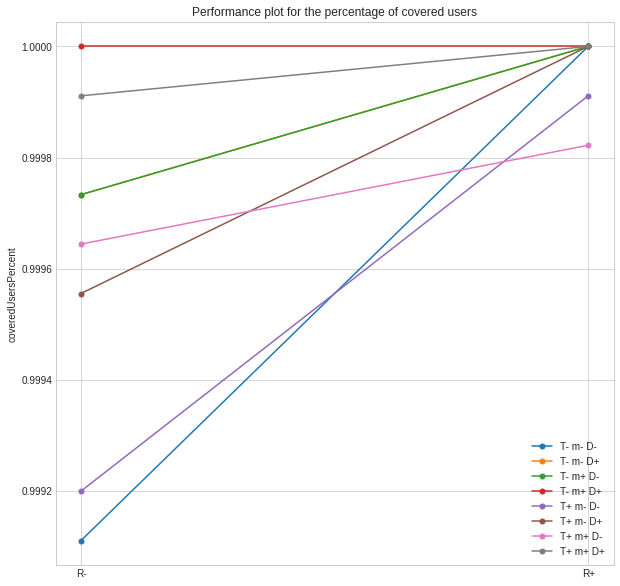

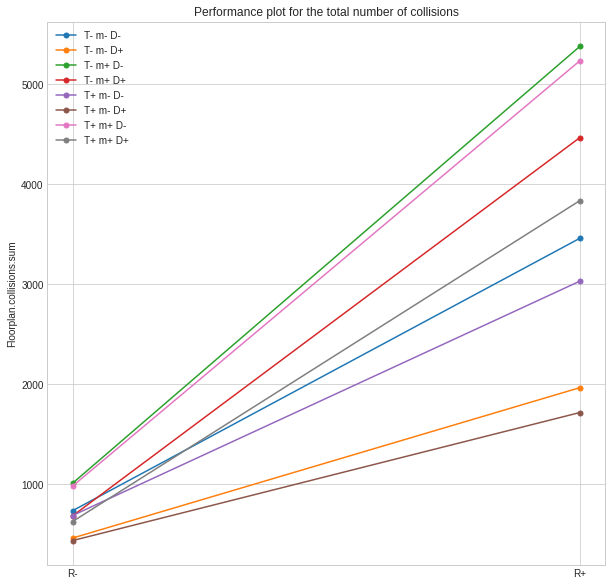

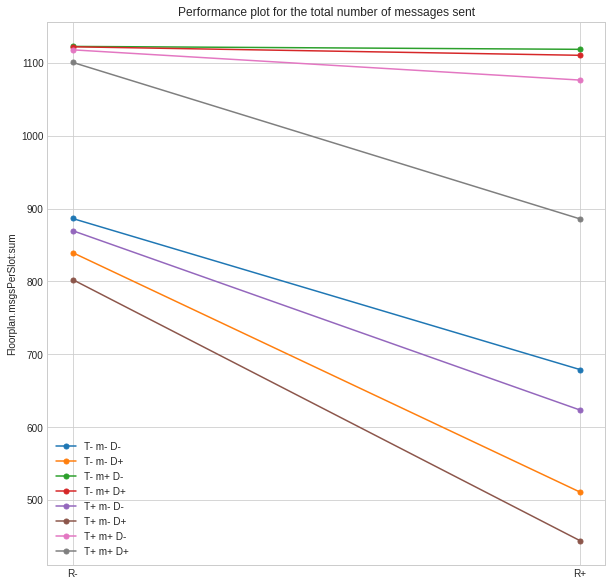

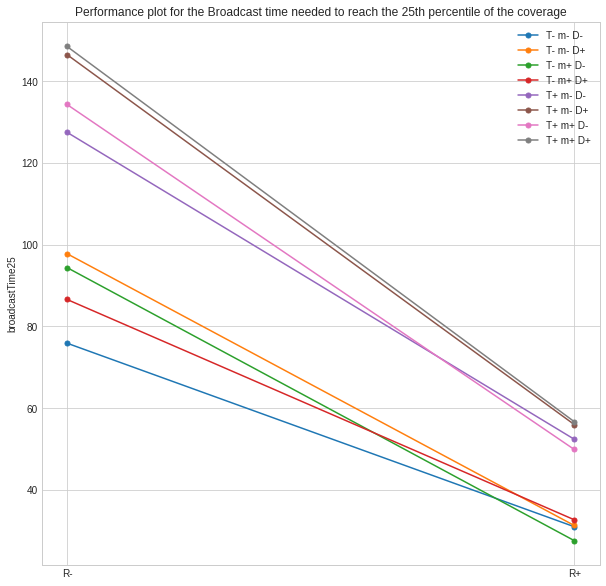

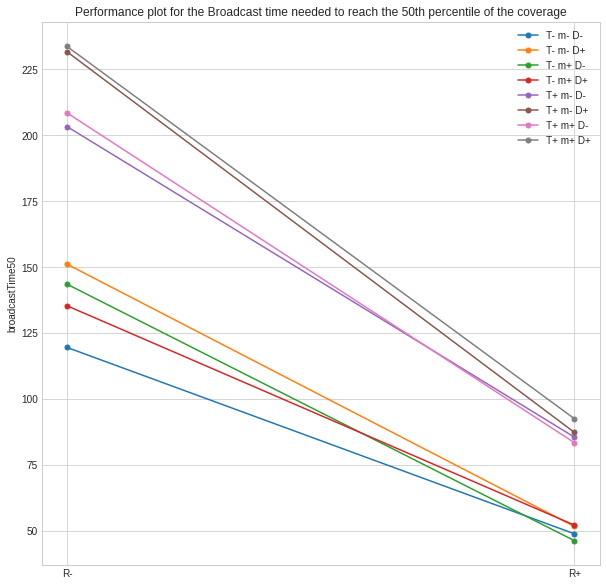

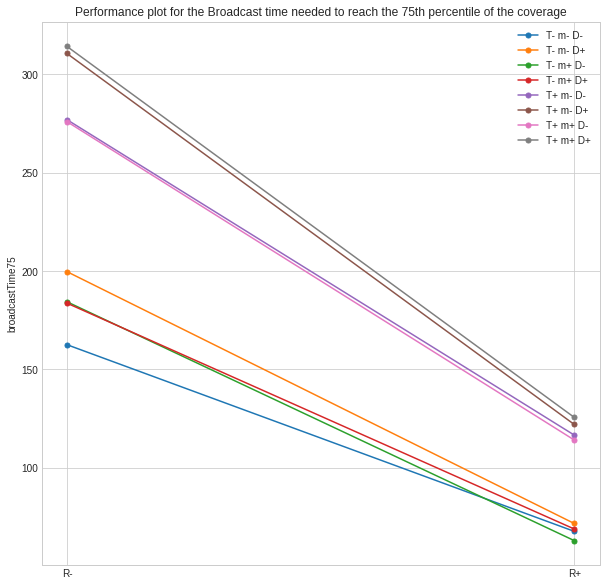

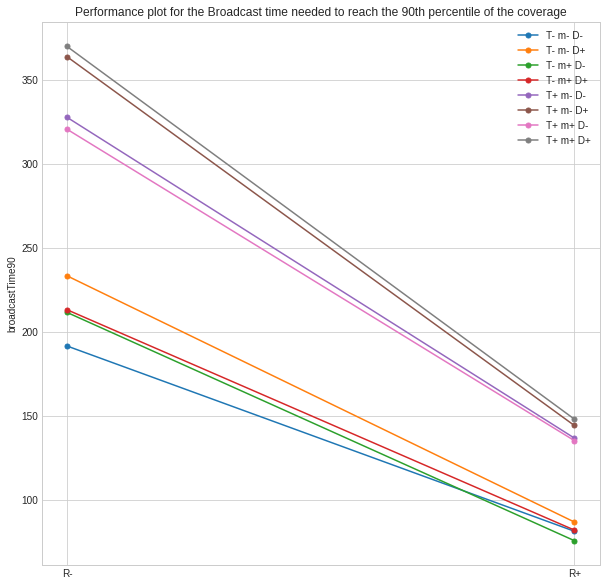

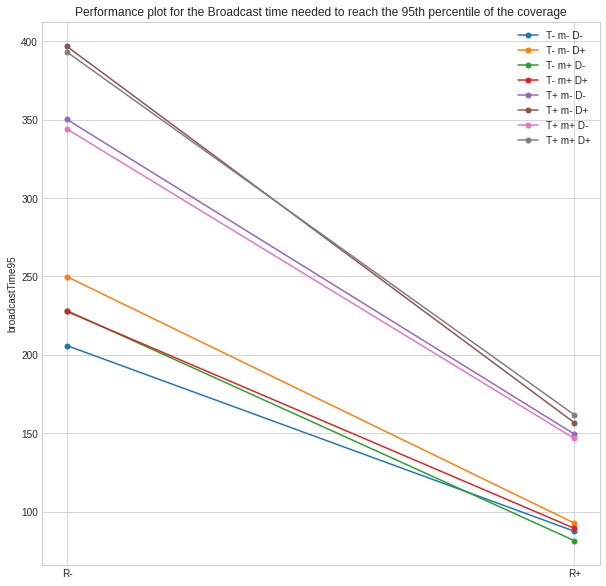

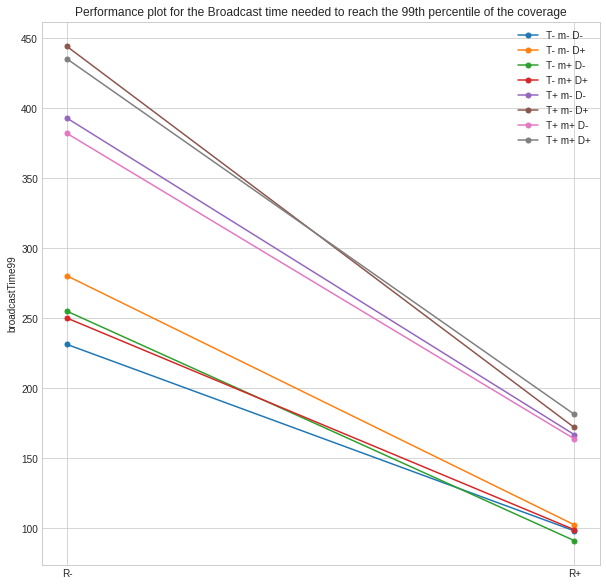

###########################

Plotting with T on the x axis...


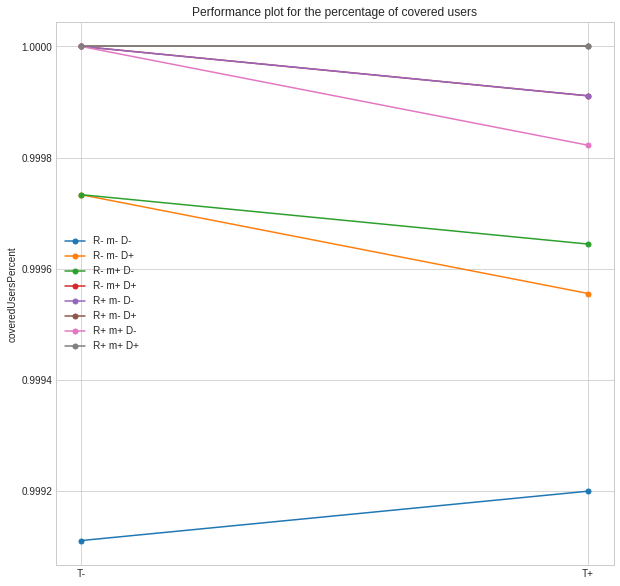

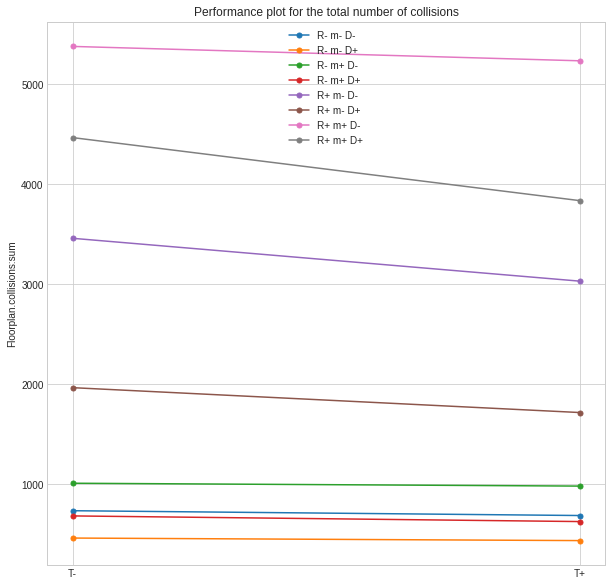

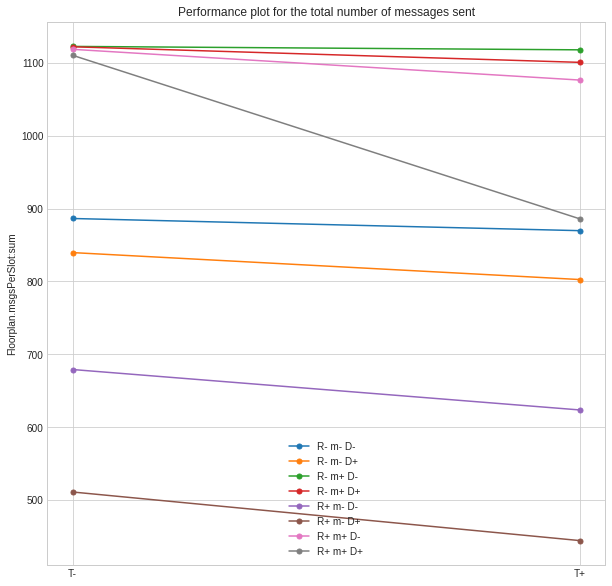

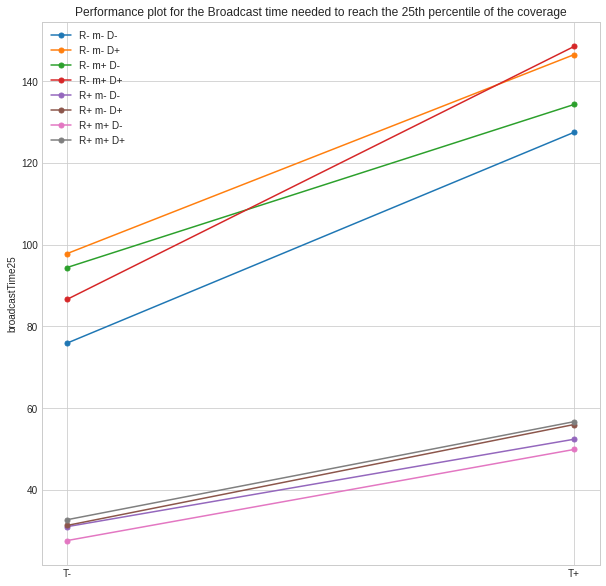

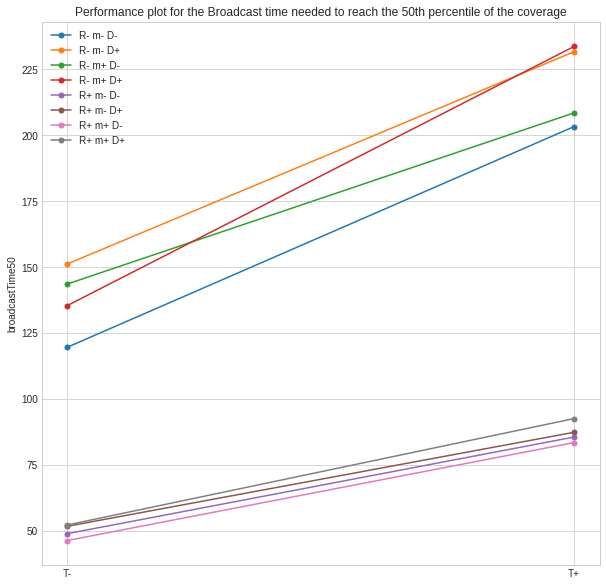

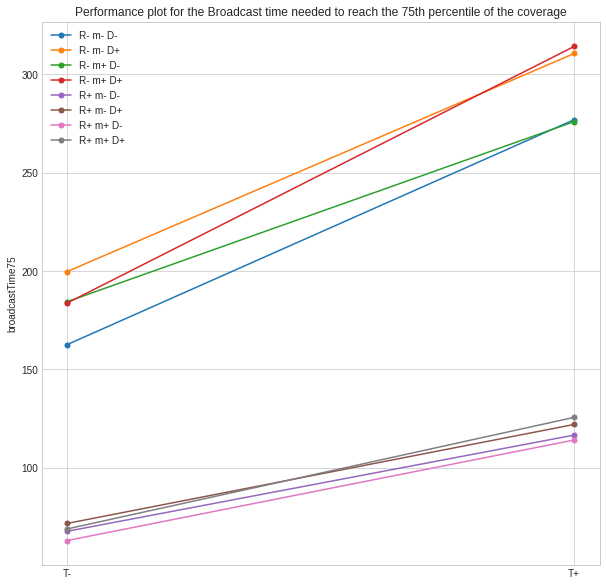

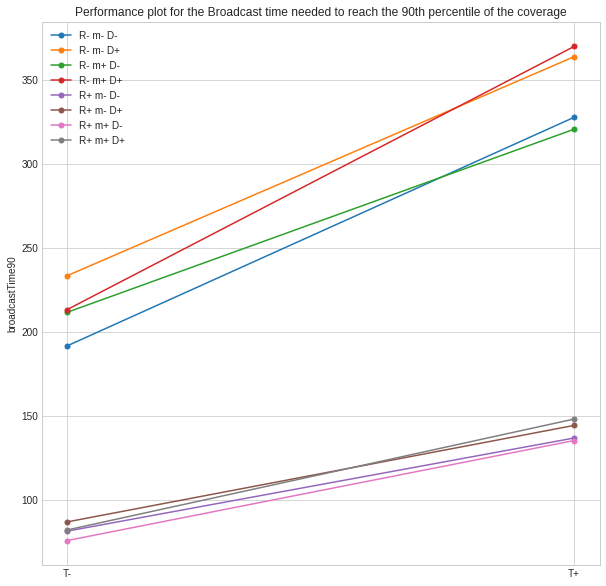

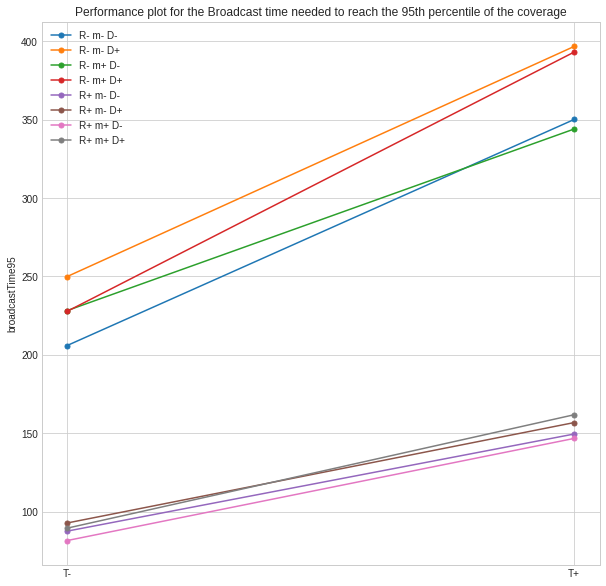

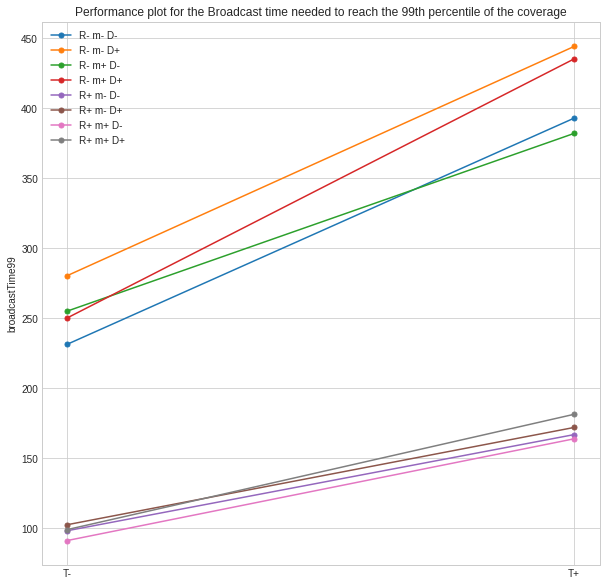

###########################

Plotting with m on the x axis...


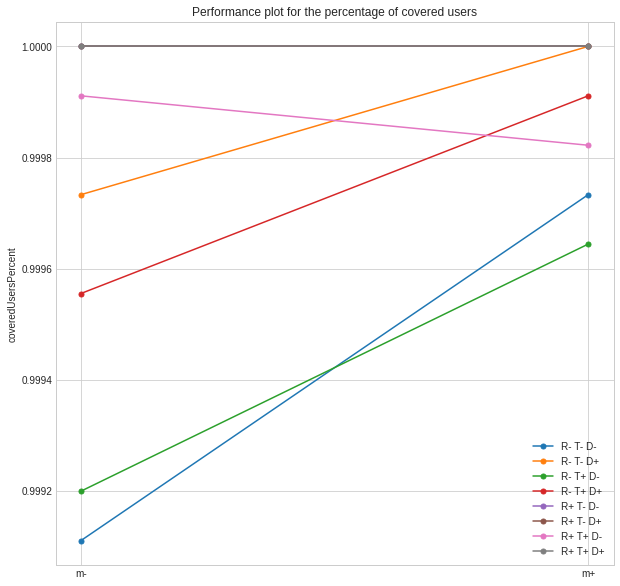

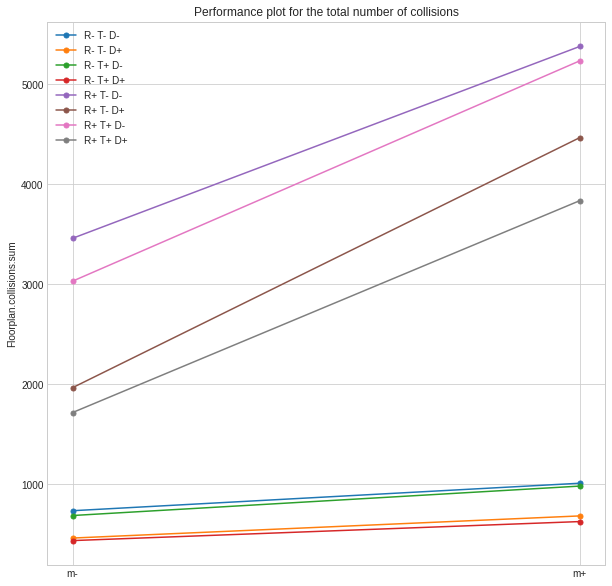

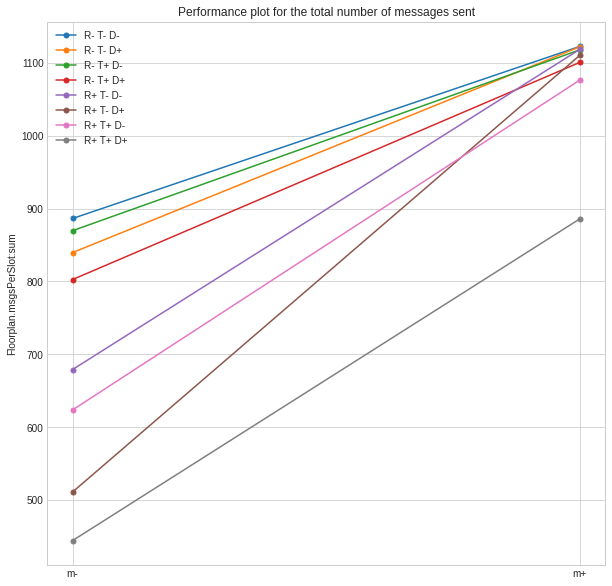

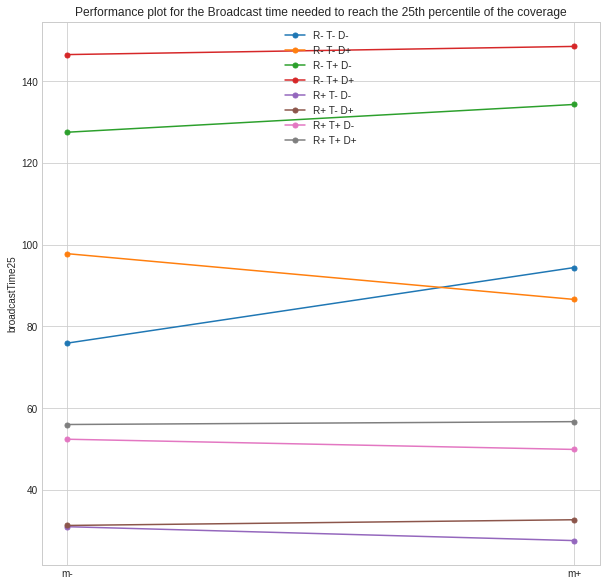

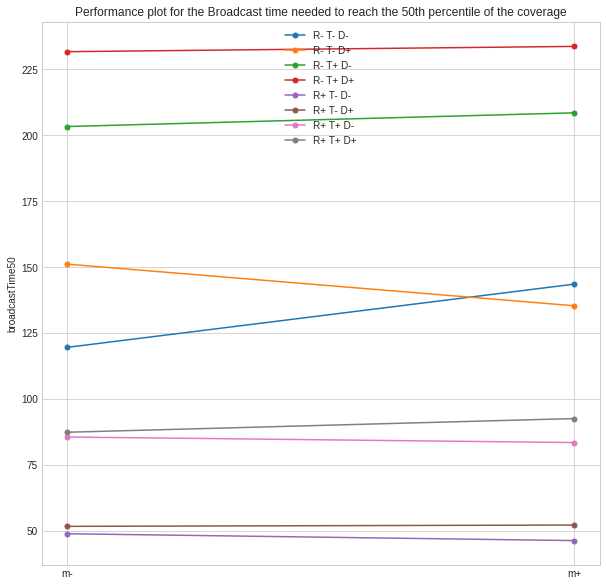

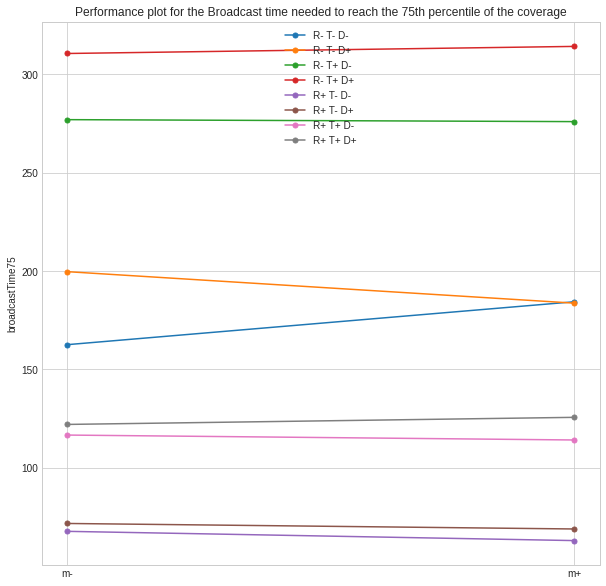

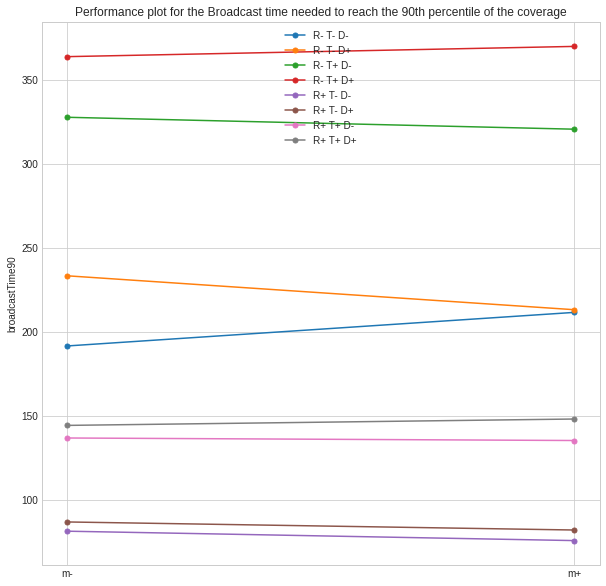

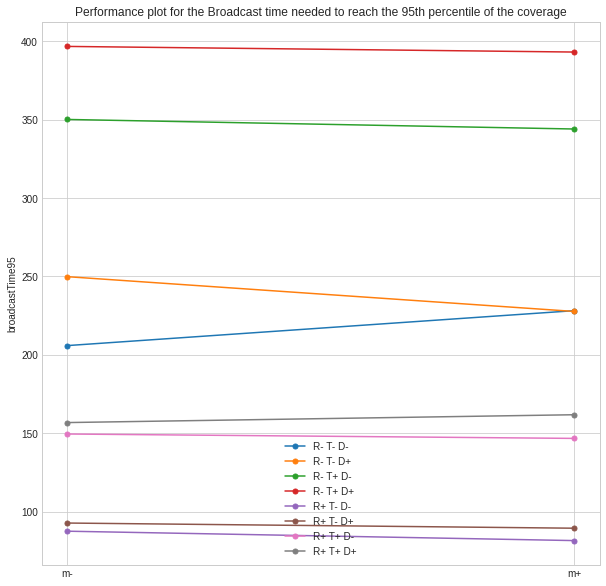

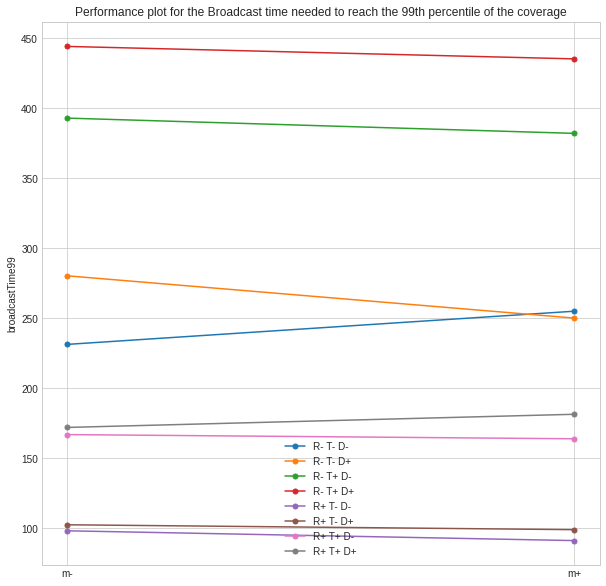

###########################

Plotting with D on the x axis...


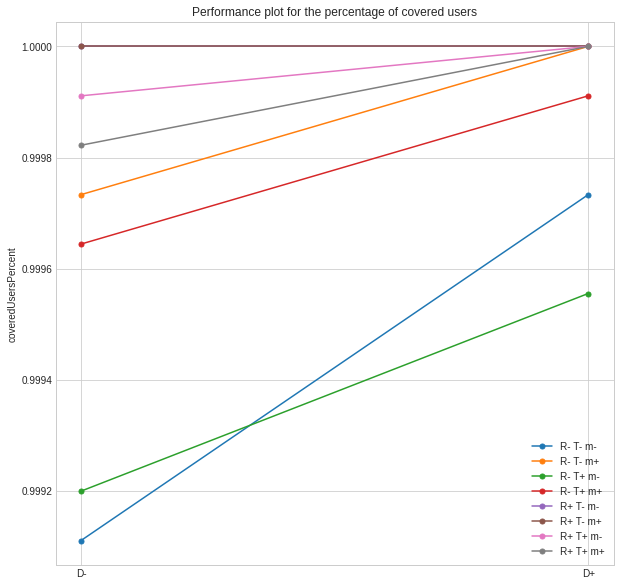

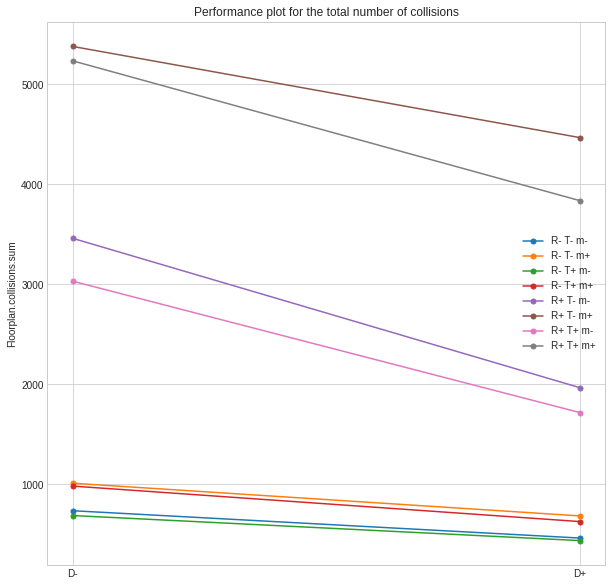

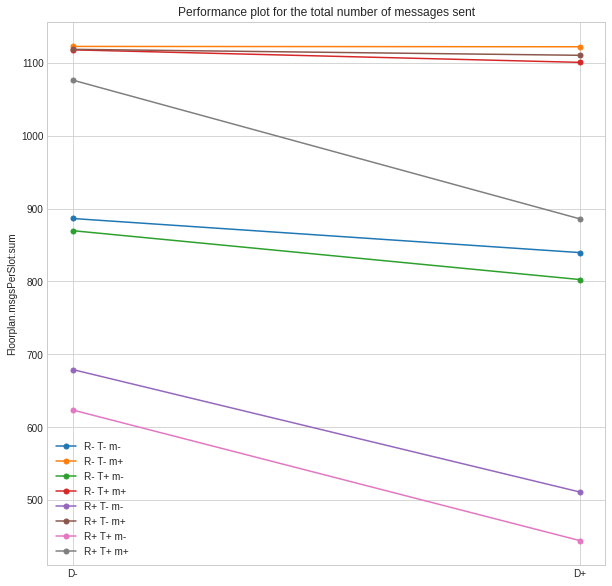

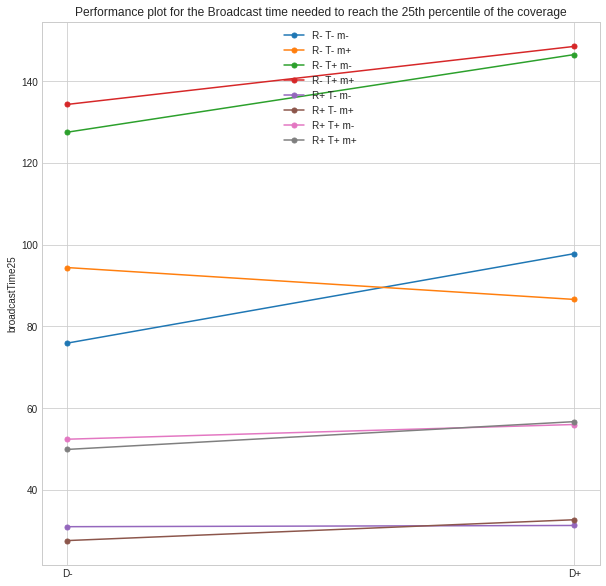

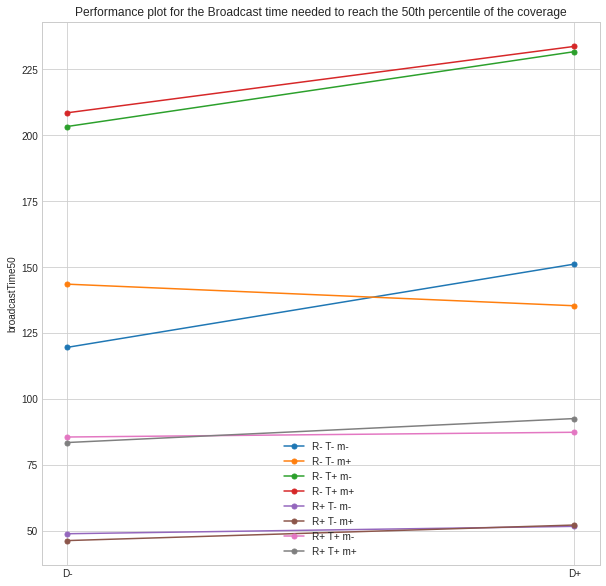

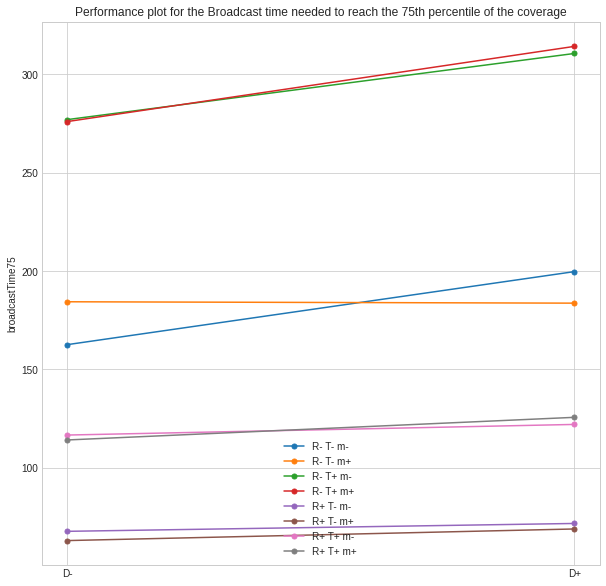

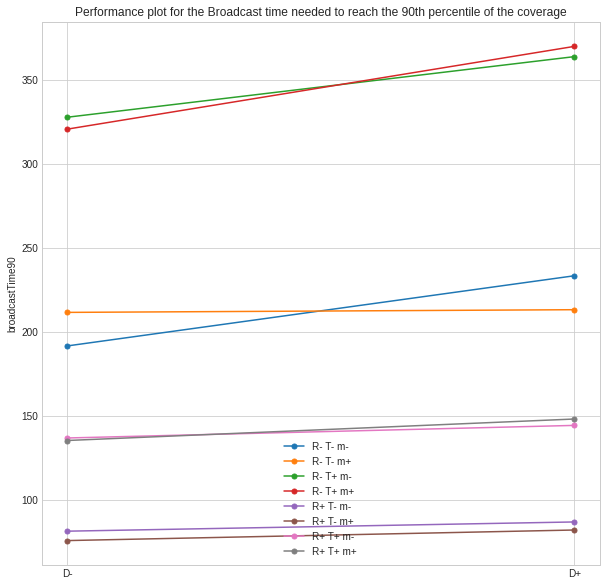

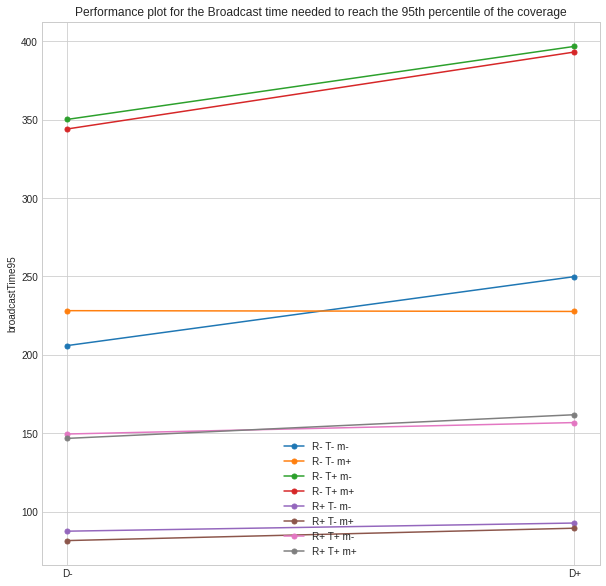

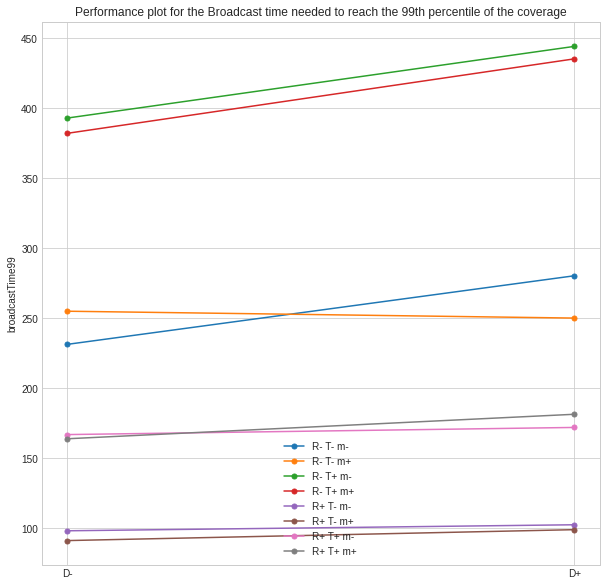

###########################



In [9]:
for xFactor in factors:
    print('Plotting with', xFactor, 'on the x axis...')
    xarr = np.array([-1, 1])
    idx = 0
    factorsMatrix.sort_values([xFactor] + [fac for fac in factors if fac != xFactor], inplace=True)
    for perfIndex, perfIndexDesc in perfIndexes:
        if perfIndex in skipped:
            continue
        ys = []
        fs = []
        for _, row in factorsMatrix.iterrows():
            y = np.sum(row[['I'] + combinedFactors].values * computeMatrices[idx].loc['Mean (Qi)', ['I'] + combinedFactors].values)
            fs.append(' '.join([f + str('+' if row[f] == 1 else '-') for f in [fac for fac in factors if fac != xFactor]]))
            ys.append(y)

        plt.figure(figsize=plotSize)
        plt.style.use(plotStyle)
        plt.xticks(xarr, (xFactor + '-', xFactor + '+'))
        ys = [y for y in zip(ys[:configsCount//2], ys[configsCount//2:])]
        for y, lbl in zip(ys, fs):
            yarr = np.array(y)
            plt.plot(xarr, yarr, linestyle='-', marker='.', markersize=10, label=lbl)
        plt.title('Performance plot for the ' + perfIndexDesc)
        plt.ylabel(perfIndex)
        plt.legend()
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(varname) + '-' + xFactor + '-perfplot.png')
        plt.show()
        idx += 1
    print('###########################')
    print()